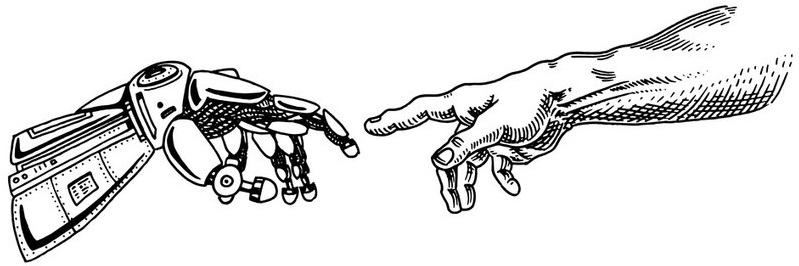

## Imports and load the data

In [136]:
import numpy as np
import pandas as pd
import os
import time
import sys
import glob
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [356]:
Spot = pd.read_csv('D:/extraFiles/Training/Shelly Social_Nuero/Shelly636759787508979097Spontan.csv')
Sync = pd.read_csv('D:/extraFiles/Training/Shelly Social_Nuero/Shelly636759789526313406Sync.csv')
Alone = pd.read_csv('D:/extraFiles/Training/Shelly Social_Nuero/Shelly636759788383205274Alone.csv')

In [357]:
Spot.shape , Sync.shape , Alone.shape

((9054, 22), (9054, 22), (4468, 22))

In [358]:
Spot.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,492.7171,57179,right,2,142.95030,211.6662,25.82943,-70.79300,-360.3060,9.442627,...,-0.924380,202.63990,186.7654,57.84925,371.3985,-2.729129,104.88020,0.0,0.567573,0.000000
1,492.7171,57179,left,2,-62.78465,197.1218,134.66050,127.69000,-69.6330,-115.599100,...,-2.371005,-65.03627,126.9338,118.71120,-216.6652,-80.858900,97.96522,0.0,1.995319,0.377631
2,492.7334,57181,right,2,141.69150,205.9972,25.73118,-80.18629,-321.4995,-4.571898,...,-0.921516,203.02640,187.2975,58.88792,387.9842,14.635980,109.91410,0.0,0.549983,0.000000
3,492.7334,57181,left,2,-60.12946,194.5126,132.21120,140.01900,-151.5517,-144.295200,...,-2.485328,-63.01408,124.5844,115.34400,-216.5888,-81.979320,96.07500,0.0,2.174709,0.936366
4,492.7501,57183,right,2,140.78350,200.5387,26.05157,-41.54920,-302.4250,24.069920,...,-0.911107,202.78510,186.3164,60.30145,400.9532,30.117770,114.87190,0.0,0.596534,0.000000


In [359]:
Sync.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,694.4501,80437,right,2,130.8101,244.8125,-9.349506,-71.45163,24.68913,203.48510,...,-0.715720,161.5550,181.4785,10.08615,308.1318,-16.57112,89.40313,0.000000,0.274505,0.000000
1,694.4501,80437,left,2,-118.6737,256.0918,29.676690,-11.11077,-25.26739,74.58345,...,0.319224,-137.3542,188.5385,49.42096,-299.9916,-10.55544,79.59129,0.070557,1.365107,0.439295
2,694.4669,80439,right,2,129.9877,246.3261,-5.432584,-57.37816,68.84872,234.26930,...,-0.768411,162.1890,183.4008,12.96071,310.7949,-14.22569,89.50893,0.000000,0.276788,0.000000
3,694.4669,80439,left,2,-118.7814,255.7271,31.032010,-11.42824,-14.63327,79.99258,...,0.330435,-137.4469,187.9098,49.90652,-298.7587,-12.35306,79.45091,0.119346,1.509837,0.598310
4,694.4836,80441,right,2,129.3127,247.4331,-1.165941,-33.42817,73.08650,254.05300,...,-0.813183,162.3709,184.5916,15.92187,313.3208,-12.00081,90.52148,0.000000,0.296602,0.000000


In [360]:
Alone.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,580.1392,67259,left,1,-108.3085,195.5176,113.3718,-3.592897,5.759355,-23.66474,...,1.405179,-151.3854,136.4591,111.0220,-305.2841,-70.87762,91.88976,0.0,0.589595,0.0
1,580.1560,67261,left,1,-108.3324,195.5074,113.0081,-2.263443,-1.267794,-20.32616,...,1.399119,-151.4667,136.4780,110.8620,-307.3874,-69.36938,92.02148,0.0,0.569350,0.0
2,580.1730,67263,left,1,-108.3228,195.4864,112.6060,-0.023640,-0.389359,-21.09858,...,1.395631,-151.4971,136.4783,110.6180,-309.3560,-67.97952,92.81544,0.0,0.549422,0.0
3,580.1890,67265,left,1,-108.3321,195.4507,112.3088,-0.922418,-2.848716,-18.13190,...,1.390733,-151.6192,136.5180,110.5340,-310.3545,-67.33633,93.62509,0.0,0.531770,0.0
4,580.2059,67267,left,1,-108.3419,195.3853,112.0646,1.664050,-6.675363,-13.15121,...,1.386362,-151.7518,136.5369,110.4735,-311.2222,-66.78359,94.06252,0.0,0.520241,0.0


In [361]:
def RemoveSevenSecond(df):
    df.drop(df[df.Time < df.head(1)["Time"][0]+7].index, inplace=True)

In [362]:
HandRight = pd.read_csv('D:/extraFiles/HandRight.csv')

In [363]:
HandRight.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [364]:
HandRight.isnull().any()

Time               False
 Frame ID          False
 Hand Type         False
 # hands           False
 Position X        False
 Position Y        False
 Position Z        False
 Velocity X        False
 Velocity Y        False
 Velocity Z        False
 Pitch             False
 Roll              False
 Yaw               False
 Wrist Pos X        True
 Wrist Pos Y        True
 Wrist Pos Z        True
 Elbow pos X        True
 Elbow Pos Y        True
 Elbow Pos Z        True
 Grab Strenth      False
 Grab Angle        False
 Pinch Strength    False
dtype: bool

In [365]:
HandRight.dropna(inplace = True)

In [366]:
HandRight.isnull().any()

Time               False
 Frame ID          False
 Hand Type         False
 # hands           False
 Position X        False
 Position Y        False
 Position Z        False
 Velocity X        False
 Velocity Y        False
 Velocity Z        False
 Pitch             False
 Roll              False
 Yaw               False
 Wrist Pos X       False
 Wrist Pos Y       False
 Wrist Pos Z       False
 Elbow pos X       False
 Elbow Pos Y       False
 Elbow Pos Z       False
 Grab Strenth      False
 Grab Angle        False
 Pinch Strength    False
dtype: bool

In [367]:
HandRight[' Hand Type'].value_counts()

right    4354
left       74
Name:  Hand Type, dtype: int64

In [368]:
i = HandRight[(HandRight[' Hand Type'] == 'left')].index

In [369]:
HandRight.drop(i, inplace = True)

In [370]:
HandRight[' Hand Type'].value_counts()

right    4354
Name:  Hand Type, dtype: int64

In [371]:
HandRight.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,...,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,...,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,...,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [372]:
HandRight[' # hands'].value_counts()

1    4314
2      40
Name:  # hands, dtype: int64

In [373]:
w = HandRight[(HandRight[' # hands'] == 2)].index

In [374]:
HandRight.drop(w, inplace = True)

In [375]:
HandRight[' # hands'].value_counts()

1    4314
Name:  # hands, dtype: int64

In [376]:
RemoveSevenSecond(HandRight)

In [377]:
HandRight.reset_index(drop=True, inplace = True)

In [378]:
HandRight.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,...,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,...,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,...,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,...,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,...,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [417]:
def HandR(frame, df):
    HandRight[" Hand Type"] = Series([1 if i == "right" else 2 for i in HandRight[" Hand Type"]])
    HandRight.insert(loc=1, column='Label', value="0")
    HandRight = HandRight.iloc[:len(frame)-1]
    HandRight = HandRight.reset_index(drop=True)
    df = pd.merge(df, HandRight, left_index=True, right_index=True)

In [418]:
def Makedataframe(CSV):
    df=pd.DataFrame()
    for CS in CSV:
        frame = pd.read_csv(CS)
        if str.__contains__(CS,"Alone"):
            HandR(frame,df)
            frame.insert(loc=1, column='Label', value="0")
        elif str.__contains__(CS,"Sync"):
            frame.insert(loc=1, column='Label', value="1")
        elif str.__contains__(CS,"Spontan"):
            frame.insert(loc=1, column='Label', value="2")
        df=pd.concat([df,frame])
    df.sort_index(inplace=True)
    return df

In [419]:
def RenameCol(df, OldName):
    temp = OldName
    if OldName[1] == " ":
        OldName = '\''+ OldName[1:]
    if OldName.isspace():
        OldName.replace(" ", "_", 1)
    df = df.rename(columns={temp : OldName}, inplace=True)

In [420]:
train = Makedataframe(glob.glob('D:/extraFiles/Training/**/*.csv', recursive=True))

UnboundLocalError: local variable 'HandRight' referenced before assignment

In [421]:
train.columns

Index(['Time', 'Label', ' Frame ID', ' Hand Type', ' # hands', ' Position X',
       ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength'],
      dtype='object')

In [422]:
train.head() , train.shape

(       Time Label   Frame ID  Hand Type   # hands   Position X   Position Y  \
 0  335.9984     2     128556      right         2    128.63570     224.0294   
 1  598.6176     2      45189      right         2    213.08350     266.1829   
 2  386.9574     0      45134       left         1   -158.61700     287.6174   
 3  291.0203     1      34075      right         2     77.93928     205.6924   
 4  175.5415     2      20769      right         2    146.66300     160.2139   
 
     Position Z   Velocity X   Velocity Y  ...       Yaw   Wrist Pos X  \
 0    -12.29588    -18.26243   -140.54450  ... -1.588251     177.51250   
 1     53.53956     35.14922   -131.81500  ... -0.727216     263.05090   
 2    -24.87604    -31.29900    356.57040  ...  1.465832    -196.78020   
 3     21.99089    -31.14405    -14.79692  ... -2.149903      96.24556   
 4    -39.06675   -292.87750    -64.44993  ... -0.444049     183.75970   
 
     Wrist Pos Y   Wrist Pos Z   Elbow pos X   Elbow Pos Y   Elbow Pos Z

In [423]:
train.reset_index(drop=True, inplace = True)

In [424]:
train

,Time,Label,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,335.9984,2,128556,right,2,128.63570,224.0294,-12.29588,-18.262430,-140.54450,...,-1.588251,177.51250,173.5658,-14.56963,276.8753,-33.68264,91.61740,0.000000,1.250576,0.000000
1,598.6176,2,45189,right,2,213.08350,266.1829,53.53956,35.149220,-131.81500,...,-0.727216,263.05090,228.0114,91.11953,437.0172,37.31987,127.90990,0.633264,1.826475,0.000000
2,386.9574,0,45134,left,1,-158.61700,287.6174,-24.87604,-31.299000,356.57040,...,1.465832,-196.78020,229.1945,-21.44019,-277.7189,10.56576,67.69565,0.000000,0.336463,0.368310
3,291.0203,1,34075,right,2,77.93928,205.6924,21.99089,-31.144050,-14.79692,...,-2.149903,96.24556,138.3030,12.82774,229.8921,-68.10480,65.34229,0.000000,0.000000,0.000000
4,175.5415,2,20769,right,2,146.66300,160.2139,-39.06675,-292.877500,-64.44993,...,-0.444049,183.75970,147.6642,18.61219,317.4607,64.20674,209.14010,0.000000,0.052556,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190957,681.8129,1,79591,left,2,-97.07718,177.0284,53.38598,246.904000,-300.97750,...,1.660854,-135.48390,116.9232,41.65805,-329.9231,-49.90217,22.16839,0.000000,0.073786,0.000000
190958,567.6977,2,65825,left,2,-142.74650,248.4907,98.42060,-5.307322,12.42717,...,-0.266009,-150.02220,176.0804,103.95920,-280.0721,-47.58023,122.80450,1.000000,2.963402,0.994508
190959,410.9792,2,137197,left,2,-102.09200,198.4801,36.82147,-143.442100,162.22250,...,1.257915,-163.84220,171.0227,50.17337,-354.1954,17.57833,25.11470,0.000000,0.729553,0.000000
190960,769.4308,1,89077,left,2,-32.25899,212.8592,111.94130,-49.526250,183.68670,...,1.368993,-82.64835,162.8196,128.82250,-245.0191,-39.73233,125.60010,0.000000,1.918167,0.084507
